<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones profond (Deep Neural Network - DNN) pour réaliser des prédictions sur notre série temporelle.  
Nous allons également utiliser une technique permettant d'optimiser l'entrainement en choisisant un taux d'apprentissage optimal.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

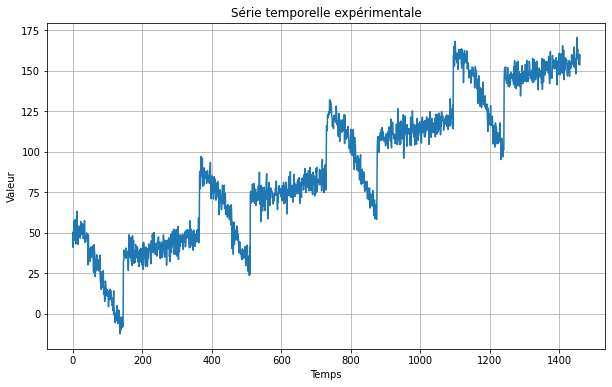

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

# Préparation des données X et Y

In [47]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

**1. Séparation des données en données pour l'entrainement et la validation**

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

In [48]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Préparation des données X et des labels Y**

On commence par créer notre dataset à partir de la série (remarque : les valeurs ci-dessous sont en réalité mélangées) :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY_2.png?raw=true" width="1200"> 

In [49]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)
#dataset = prepare_dataset_XY(serie,taille_fenetre,batch_size,buffer_melange)


# Création et entrainement du modèle

**1. Création du réseau**

On met maintenant en place un réseau de neurones profond constitué de :
-  **D'une couche d'entrée avec 10 neurones** avec une **fonction d'activation de type "relu"** qui prend en entrée des **vecteurs 1D de dimension égale à la taille de la fenêtre** avec un **batch_size** de 32.  
On a donc ici : 20*10 poids + 10 offsets = 210 paramètres
- **Une couche profonde à 10 neurones**, avec une **fonction d'activation de type "relu"**  
On a donc ici : 10*10 poids + 10 offsets = 110 paramètres
- D'une **couche de sortie à 1 neurone** sans fonction d'activation  
On a donc ici : 10 poids + 1 offset = 11 paramètres

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/DNN_1.png?raw=true" width="1200"> 


Pour les paramètre de compilation du modèle :
- On utilise un **taux d'apprentissage de 1e-6**
- On choisit un **optimiseur de type Descente de gradient stochastique et à moment** (MSGD - Momentum Stochastic Gradient Descent) avec un moment fixé à 0.9.  
- On utilise une **fonction d'objectif** de type **erreur moyenne quadratique** (mse - mean squared error)

In [51]:
# Création du modèle à réseau de neurones profonds

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(10,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="relu"))
model.add(tf.keras.layers.Dense(1))

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (32, 10)                  210       
_________________________________________________________________
dense_13 (Dense)             (32, 10)                  110       
_________________________________________________________________
dense_14 (Dense)             (32, 1)                   11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


**2. Entrainement du réseau**

On entraine le réseau sur 100 périodes. Comme le modèle prend 1 élément (vecteur d'entrée X de dimension 20) à chaque itération, et qu'il y a 45 éléments, il y aura 45 itérations par période.  
Pour entrainer notre réseau, on lui rentre un Dataset au format tensorflow. La méthode [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) de la classe Model de Keras permet de gérer ce genre d'entrée. Dans ce cas, le Dataset doit être au format `(entrées, labels)`, ce qui est notre cas.

In [52]:
# Lance l'entrainement du modèle

model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
30/30 [==============================] - 0s 3ms/step - loss: 2992.4644
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 171.4827
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 111.7689
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 99.0408
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 80.9161
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 88.9103
Epoch 7/100
30/30 [==============================] - 0s 1ms/step - loss: 85.6814
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 79.0527
Epoch 9/100
30/30 [==============================] - 0s 2ms/step - loss: 76.8106
Epoch 10/100
30/30 [==============================] - 0s 2ms/step - loss: 76.2526
Epoch 11/100
30/30 [==============================] - 0s 2ms/step - loss: 78.9035
Epoch 12/100
30/30 [==============================] - 0s 2ms/step - loss: 76.6083
Epoch 13/100
30/30 [=

# Prédictions avec le modèle

In [53]:
# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

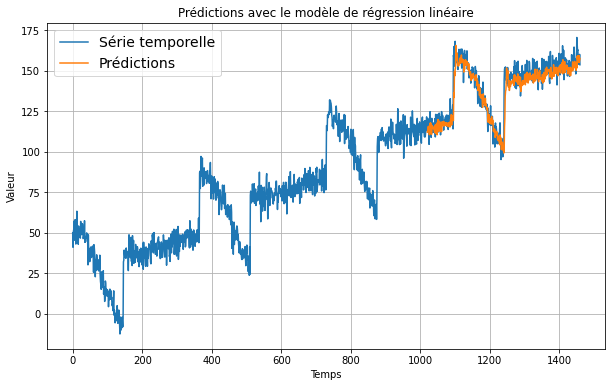

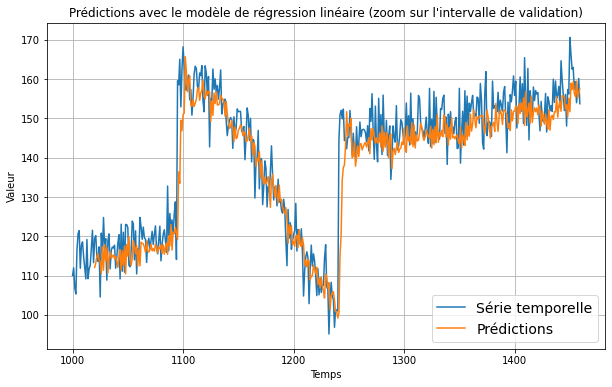

In [54]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

**Erreurs de prédiction**

On peut calculer l'erreur quadratique moyenne et l'erreur absolue moyenne. On otient des résultats identiques, voire inférieurs à ceux obtenus avec les méthodes statistiques vues précédemment :

In [55]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

5.187016
52.516975


# Optimisation du taux d'apprentissage 

**1. Evolution de l'erreur en fonction du taux d'apprentissage**

Afin de trouver la valeur optimale pour le taux d'apprentissage, nous allons regarder comment évolue l'erreur en fonction du taux d'apprentissage. Pour mettre en place un taux d'apprentissage qui varie à chaque période, Keras nous propose [plusieurs méthodes](https://keras.io/api/optimizers/learning_rate_schedules/) qui peuvent être implantées dans la classe de l'optimiseur. C'est ce que nous avions fait lors de la mise en place du réseau VDSR.

Cette fois, nous allons implanter notre propre algorithme de régulation. Pour cela, nous allons utiliser la classe [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/) de Keras. Cela nous permet d'appeler une fonction spécifique qui reçoit en argument le numéro de la période d'entrainement et le taux d'apprentissage courant et retourne le nouveau taux d'apprentissage souhaité.

La fonction que nous allons utiliser est la suivante : $
Taux = {10^{ - 8}}{.10^{\left( {\frac{{Periode}}{{20}}} \right)}}$

In [57]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

In [58]:
# Création du modèle à réseau de neurones profonds
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(10,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="relu"))
model.add(tf.keras.layers.Dense(1))

# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/20)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

# Compile le modèle
model.compile(loss="mse", optimizer=optimiseur)

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage)])

Epoch 1/100
30/30 [==============================] - 0s 2ms/step - loss: 1064.6053
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 176.3056
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 174.4719
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 170.2289
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 146.2371
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 141.2843
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - loss: 137.2128
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 137.6457
Epoch 9/100
30/30 [==============================] - 0s 2ms/step - loss: 128.0288
Epoch 10/100
30/30 [==============================] - 0s 2ms/step - loss: 114.3450
Epoch 11/100
30/30 [==============================] - 0s 2ms/step - loss: 113.3576
Epoch 12/100
30/30 [==============================] - 0s 1ms/step - loss: 108.6541
Epoch 13/100

**2. Exploitation des résultats**

Nous pouvons maintenant regarder comment évolue l'erreur en fonction du taux d'apprentissage :

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

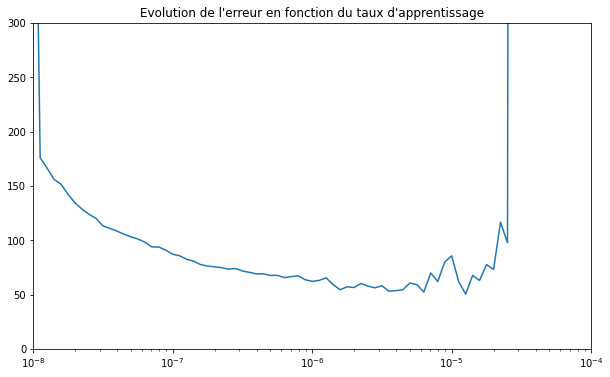

In [59]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/20))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ 1e-8, 1e-4, 0, 300])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

On peut récupérer la valeur optimale du taux d'apprentissage et relancer l'entrainement avec cette valeur :

In [60]:
# Création du modèle à réseau de neurones profonds

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(taille_fenetre,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(10,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="relu"))
model.add(tf.keras.layers.Dense(1))

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9))
historique = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
30/30 [==============================] - 0s 2ms/step - loss: 1717.8347
Epoch 2/500
30/30 [==============================] - 0s 2ms/step - loss: 98.6420
Epoch 3/500
30/30 [==============================] - 0s 2ms/step - loss: 53.7274
Epoch 4/500
30/30 [==============================] - 0s 2ms/step - loss: 45.9734
Epoch 5/500
30/30 [==============================] - 0s 3ms/step - loss: 43.1757
Epoch 6/500
30/30 [==============================] - 0s 2ms/step - loss: 56.5366
Epoch 7/500
30/30 [==============================] - 0s 1ms/step - loss: 48.1703
Epoch 8/500
30/30 [==============================] - 0s 2ms/step - loss: 42.0692
Epoch 9/500
30/30 [==============================] - 0s 2ms/step - loss: 47.1072
Epoch 10/500
30/30 [==============================] - 0s 3ms/step - loss: 40.8953
Epoch 11/500
30/30 [==============================] - 0s 2ms/step - loss: 48.0800
Epoch 12/500
30/30 [==============================] - 0s 2ms/step - loss: 50.2039
Epoch 13/500
30/30 [===

On affiche maintenant l'évolution de l'erreur en fonction des périodes :

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

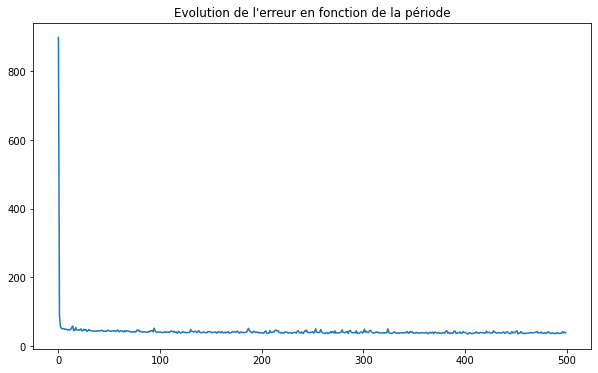

In [63]:
erreur = historique.history["loss"]
periodes = np.arange(0,500)

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(periodes,erreur)

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

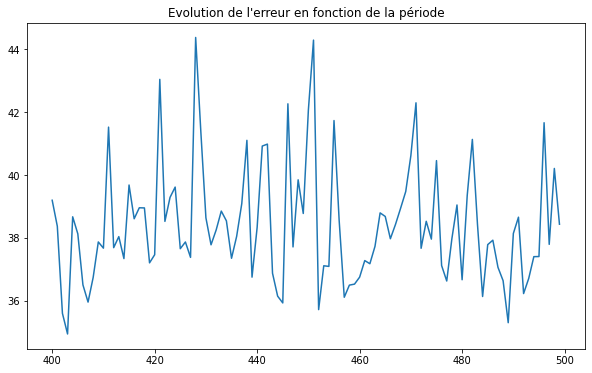

In [64]:
# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(periodes[400:500],erreur[400:500])

plt.title("Evolution de l'erreur en fonction de la période")

**3. Prédictions**

In [65]:
# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

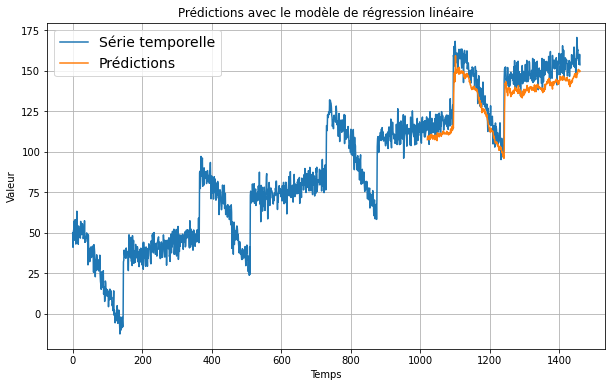

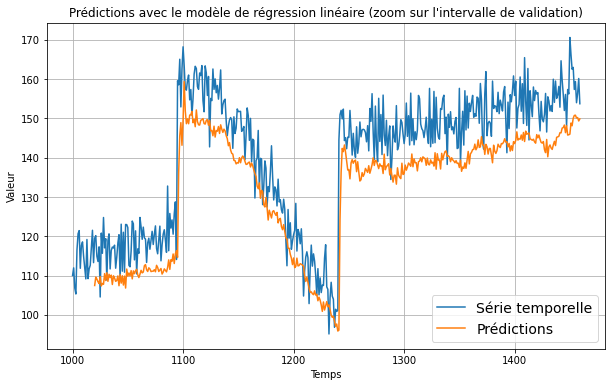

In [66]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [67]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

8.928937
110.06829
